In [ ]:
raw_data_df = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/wenhuans@andrew.cmu.edu/output_copy.csv")
num_points = raw_data_df.count()
print (num_points)
sample_points = raw_data_df.take(1)
print (sample_points)


10001
[Row(_c0='artist_name', _c1='title', _c2='artist_location', _c3='artsit_latitude', _c4=' artist_longitude', _c5=' release', _c6='artist_hotttness', _c7='familiarity', _c8='danceability', _c9='duration', _c10='energy', _c11='loudness', _c12='year', _c13='tempo', _c14='analysis_rate', _c15='end_of_fade_in', _c16='key', _c17='key_confidence', _c18='mode', _c19='mode_confidence', _c20='start_of_fade_out', _c21='time_signature', _c22='time_signature_conf', _c23=' song_hotttness')]

In [ ]:
# remove header
print(raw_data_df.columns)
cn = ['artist_name', 'title', 'artist_location', 'artsit_latitude', ' artist_longitude', ' release', 'artist_hotttness', 'familiarity', 'danceability', 'duration', 'energy', 'loudness', 'year', 'tempo', 'analysis_rate', 'end_of_fade_in', 'key', 'key_confidence', 'mode', 'mode_confidence', 'start_of_fade_out', 'time_signature', 'time_signature_conf', ' song_hotttness']
raw_data_df = raw_data_df.toDF(*cn)
sample = df.take(1)
print(sample_points)
raw_data_df = raw_data_df.filter(raw_data_df.artist_name != 'artist_name')
print(raw_data_df.take(1))


['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20', '_c21', '_c22', '_c23']
[Row(_c0='artist_name', _c1='title', _c2='artist_location', _c3='artsit_latitude', _c4=' artist_longitude', _c5=' release', _c6='artist_hotttness', _c7='familiarity', _c8='danceability', _c9='duration', _c10='energy', _c11='loudness', _c12='year', _c13='tempo', _c14='analysis_rate', _c15='end_of_fade_in', _c16='key', _c17='key_confidence', _c18='mode', _c19='mode_confidence', _c20='start_of_fade_out', _c21='time_signature', _c22='time_signature_conf', _c23=' song_hotttness')]
[Row(artist_name='Raphaël', title='Je Sais Que La Terre Est Plate', artist_location='France', artsit_latitude='1.71819', artist_longitude='46.71067', release='Je Sais Que La Terre Est Plate Deluxe', artist_hotttness='0.3861516314132549', familiarity='0.5574602197393447', danceability='0.0', duration='148.74077', energy='0.0', loudness='-9.636', year='2008', tempo='124.059', analysis_rate='22050', end_of_fade_in='0.192', key='0', key_confidence='0.591', mode='1', mode_confidence='0.556', start_of_fade_out='141.607', time_signature='4', time_signature_conf='0.372', song_hotttness='0.5479529419800353')]

In [ ]:
# remove non-numerical and constant features
drop = cn[:6]
drop.extend(['danceability', 'energy', 'analysis_rate'])
print('dropping these: ',drop)
cols = [i for i in cn if i not in drop]
df = raw_data_df.drop(*drop)
df.show(2)



dropping these: ['artist_name', 'title', 'artist_location', 'artsit_latitude', ' artist_longitude', ' release', 'danceability', 'energy', 'analysis_rate']
+-------------------+------------------+---------+--------+----+-------+--------------+---+--------------+----+---------------+-----------------+--------------+-------------------+-------------------+
 artist_hotttness| familiarity| duration|loudness|year| tempo|end_of_fade_in|key|key_confidence|mode|mode_confidence|start_of_fade_out|time_signature|time_signature_conf| song_hotttness|
+-------------------+------------------+---------+--------+----+-------+--------------+---+--------------+----+---------------+-----------------+--------------+-------------------+-------------------+
 0.3861516314132549|0.5574602197393447|148.74077| -9.636|2008|124.059| 0.192| 0| 0.591| 1| 0.556| 141.607| 4| 0.372| 0.5479529419800353|
0.43485958934341257|0.6269577230052118|252.99546| -11.061|2004| 80.084| 0.514| 1| 0.429| 0| 0.67| 241.424| 4| 0.533|0.47563846801023907|
+-------------------+------------------+---------+--------+----+-------+--------------+---+--------------+----+---------------+-----------------+--------------+-------------------+-------------------+
only showing top 2 rows

In [ ]:
# drop rows with not meaningful features
cn_new = df.schema.names
for c in cn_new:
  df = df.filter(df[c] != 'nan')
print('num_col before dropping 0 hotttnesss', df.count())

num_col before dropping 0 hotttnesss 5646

In [ ]:
# remove rows with 0 hotttness
df = df.filter(df[cn_new[-1]] !='0.0')
print('num_col after dropping 0 hotttnesss', df.count())

num_col after dropping 0 hotttnesss 4214

In [ ]:
# convirt to float
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
df = df.select(*(col(c).cast("float").alias(c) for c in df.columns))
# df.take(1)
# obtain mean and std of each column/feature, except the label
mean_d = dict() # todo broadcast this
std_d = dict() # todo broadcast this
for c in cn_new[:-1]:
  df_stats = df.select(
      _mean(col(c)).alias('mean'),
      _stddev(col(c)).alias('std')
  ).collect()
  mean = df_stats[0]['mean']
  std = df_stats[0]['std']
  mean_d[c] = mean
  std_d[c] = std
print('stats, mean', mean_d)  
print('stats, std', std_d)  
df.take(1)


stats, mean {'artist_hotttness': 0.43388117034068685, 'familiarity': 0.6235659201518956, 'duration': 240.85178067053897, 'loudness': -9.564173712626305, 'year': 1286.2992406264832, 'tempo': 124.52316682079588, 'end_of_fade_in': 0.7636623160863197, 'key': 5.318699572852397, 'key_confidence': 0.45531229276851987, 'mode': 0.6867584242999525, 'mode_confidence': 0.48227361181780065, 'start_of_fade_out': 231.92609038033868, 'time_signature': 3.6203132415757002, 'time_signature_conf': 0.5226803512133898}
stats, std {'artist_hotttness': 0.11946690873250566, 'familiarity': 0.14199900226953277, 'duration': 103.11778642149028, 'loudness': 5.035494347324147, 'year': 957.4125385469449, 'tempo': 34.68441346672436, 'end_of_fade_in': 1.8451120729212, 'key': 3.517984261221546, 'key_confidence': 0.2754617854588272, 'mode': 0.46386673976593934, 'mode_confidence': 0.18913623012209935, 'start_of_fade_out': 101.26029429241188, 'time_signature': 1.2156996958214632, 'time_signature_conf': 0.37180108603706813}
Out[210]: [Row(artist_hotttness=0.38615164160728455, familiarity=0.5574602484703064, duration=148.7407684326172, loudness=-9.63599967956543, year=2008.0, tempo=124.05899810791016, end_of_fade_in=0.19200000166893005, key=0.0, key_confidence=0.5910000205039978, mode=1.0, mode_confidence=0.5559999942779541, start_of_fade_out=141.60699462890625, time_signature=4.0, time_signature_conf=0.3720000088214874, song_hotttness=0.5479529500007629)]

In [ ]:
from pyspark.sql import Row

def helpParse(row):
  ans = []
  counter = 0
  for s in row: # take note: each row is an iterable if col items!, row[0] is necessary
    if counter < len(row) -1:
      name = cn_new[counter]
      ans.append((s - mean_d[name])/std_d[name])
    else:
      ans.append(s)
    counter += 1
#     ans.append(s)
  return Row(label = ans[-1], features = ans[:-1])

def parse_points(df):
  df2 = (df.rdd.map(lambda row: helpParse(row)).toDF())
  return df2

parsed_points_df = parse_points(df)
parsed_points_df.take(1)

Out[211]: [Row(features=[-0.39952091537140116, -0.46553617014936455, -0.8932601778457627, -0.014263935571150623, 0.7538033296167549, -0.013382631173251306, -0.30982525278929435, -1.5118599680731917, 0.4925827642824124, 0.6752835434118533, 0.3898057099507505, -0.8919497655281913, 0.3123195306615099, -0.40527138852111844], label=0.5479529500007629)]

In [ ]:
parsed_data_df = parsed_points_df.select(parsed_points_df.features, parsed_points_df.label)

In [ ]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np
weights = [.8, .1, .1]
seed = 42
parsed_train_data_df, parsed_val_data_df, parsed_test_data_df = parsed_data_df.randomSplit(weights, seed)
parsed_train_data_df.cache()
parsed_val_data_df.cache()
parsed_test_data_df.cache()
n_train = parsed_train_data_df.count()
n_val = parsed_val_data_df.count()
n_test = parsed_test_data_df.count()


# YOUR CODE HERE
# raise NotImplementedError()

print (n_train, n_val, n_test, n_train + n_val + n_test)
print (parsed_data_df.count())

3411 397 406 4214
4214

In [ ]:
# Create and evaluate a baseline model
average_train_hotttness = (parsed_train_data_df
                        .selectExpr('mean(label)')).collect()[0][0] # take note: 1st [0] to get the row, and 2nd [0] index into the row
print(average_train_hotttness)

0.45858138956498695

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

preds_and_labels = [(1., 3.), (2., 1.), (2., 2.)]
preds_and_labels_df = sqlContext.createDataFrame(preds_and_labels, ["prediction", "label"]) # take note: record this

# RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse', weightCol=None, throughOrigin=False)
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')
# YOUR CODE HERE
# raise NotImplementedError()

def calc_RMSE(dataset):
    """Calculates the root mean squared error for an dataset of (prediction, label) tuples.

    Args:
        dataset (DataFrame of (float, float)): A `DataFrame` consisting of (prediction, label) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return evaluator.evaluate(dataset)
example_rmse = calc_RMSE(preds_and_labels_df)
print (example_rmse)

1.2909944487358058

In [ ]:
# Training, validation and test RMSE
# print(parsed_train_data_df.rdd.map(lambda row: [average_train_hotttnesss, row[1]]).take(1))
preds_and_labels_train = parsed_train_data_df.rdd.map(lambda row: [average_train_hotttness, row[1]])

preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
rmse_train_base = calc_RMSE(preds_and_labels_train_df)

preds_and_labels_val = parsed_val_data_df.rdd.map(lambda row: [average_train_hotttness, row[1]])
preds_and_labels_val_df = sqlContext.createDataFrame(preds_and_labels_val, ["prediction", "label"])
rmse_val_base = calc_RMSE(preds_and_labels_val_df)

preds_and_labels_test = parsed_test_data_df.rdd.map(lambda row: [average_train_hotttness, row[1]])
preds_and_labels_test_df = sqlContext.createDataFrame(preds_and_labels_test, ["prediction", "label"])
rmse_test_base = calc_RMSE(preds_and_labels_test_df)



# YOUR CODE HERE
# raise NotImplementedError()

print ('Baseline Train RMSE = {0:.3f}'.format(rmse_train_base))
print ('Baseline Validation RMSE = {0:.3f}'.format(rmse_val_base))
print ('Baseline Test RMSE = {0:.3f}'.format(rmse_test_base))

Baseline Train RMSE = 0.169
Baseline Validation RMSE = 0.170
Baseline Test RMSE = 0.159

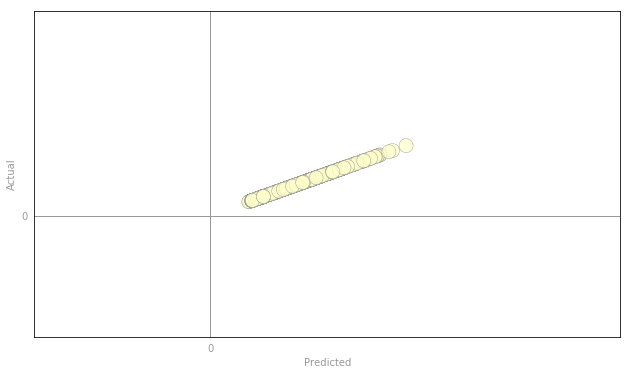

In [ ]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
cmap = get_cmap('YlOrRd')
norm = Normalize()
def prepare_plot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                 gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax
def squared_error(lp):
    """Calculates the squared error for a single prediction."""
    label, prediction = lp
    return float((label - prediction)**2)

actual = np.asarray(parsed_val_data_df
                    .select('label')
                    .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp: squared_error(lp))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig)

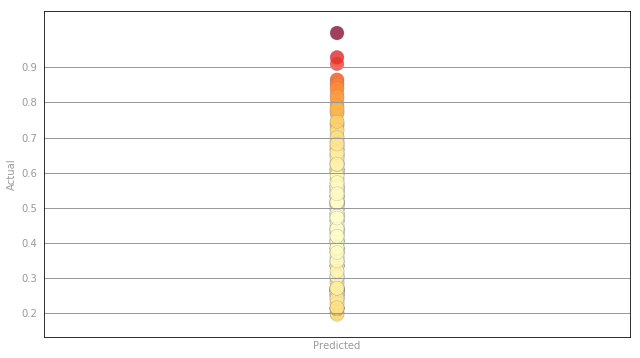

In [ ]:

predictions = np.asarray(parsed_val_data_df
                         .rdd
                         .map(lambda lp: average_train_hotttness)
                         .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, average_train_hotttness))
                   .map(lambda lp: squared_error(lp))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1))
# ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig)

In [ ]:
# Train using SparkML and perform grid search
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [ ]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code

# The data parameter takes in the training data that is an RDD of LabeledPoint. 
# You may want to transform parsed_train_data_df to required type via map.
first_model = LinearRegressionWithSGD.train(data=parsed_train_data_df.rdd
                 .map(lambda lp: LabeledPoint(lp.label, lp.features)), 
                                           iterations=numIters, 
                                           step=alpha, 
                                           miniBatchFraction=miniBatchFrac, 
                                           initialWeights=None, 
                                           regParam=reg, 
                                           regType=regType, 
                                           intercept=useIntercept)

# coeffsLR1 stores the model coefficients; interceptLR1 stores the model intercept
coeffs_LR1 = first_model.weights
intercept_LR1 = first_model.intercept
print (coeffs_LR1, intercept_LR1)


# YOUR CODE HERE
# raise NotImplementedError()


[0.03717729460540631,0.04059737522211379,0.0017018268675971322,0.01245564475305384,0.03133144731494264,0.004105646832913381,-0.0012549172352716077,-0.0022741533920990673,-0.0007683689673192639,-0.0034784834314056517,0.0013362160034377426,0.0007044040678886105,0.002450041675671607,-0.0009813888871299504] 0.4164306238688236

In [ ]:
# prediction
samplePoint = parsed_train_data_df.take(1)[0]
sample_prediction = first_model.predict(samplePoint.features)
print (sample_prediction)

0.04188494365143136

In [ ]:
labels_and_preds = parsed_val_data_df.rdd.map(lambda lp: (lp.label, float(first_model.predict(lp.features))))
    
labels_and_preds_df = sqlContext.createDataFrame(labels_and_preds, ["label", "prediction"])

rmse_val_LR1 = calc_RMSE(labels_and_preds_df)

# YOUR CODE HERE
# raise NotImplementedError()


print(rmse_val_LR1)

0.14744312015336125

In [ ]:
# grid search
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
best_RMSE = rmse_val_LR1
best_reg_param = reg
best_model = first_model
regType = 'l2'  # regType
useIntercept = True  # intercept
num_iters = 500  # iterations
alpha = 1.0 # step
miniBatchFrac = 1.0

for reg in [1e-10, 1e-5, 1.0]:
    model = LinearRegressionWithSGD.train(data = parsed_train_data_df.rdd
                                         .map(lambda lp: LabeledPoint(lp.label, lp.features)),
                                         iterations=numIters,
                                         step=alpha,
                                         miniBatchFraction=miniBatchFrac,
                                         initialWeights=None,
                                         regParam=reg,
                                         regType=regType,
                                         intercept=useIntercept)
    labels_and_preds = parsed_val_data_df.rdd.map(lambda lp: (lp.label, float(model.predict(lp.features))))
    
    labels_and_preds_df = sqlContext.createDataFrame(labels_and_preds, ["label", "prediction"])
    rmse_val_grid = calc_RMSE(labels_and_preds_df)
    print (rmse_val_grid)

    if rmse_val_grid < best_RMSE:
        best_RMSE = rmse_val_grid
        best_reg_param = reg
        best_model = model

rmse_val_LR_grid = best_RMSE

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\t\n\tLR1 = {1:.3f}\n' +
       '\tLRGrid = {2:.3f}').format(rmse_val_base, rmse_val_LR1, rmse_val_LR_grid))

# YOUR CODE HERE
# raise NotImplementedError()


0.1394083000775679
0.13940849178438963
0.2758058623034964
Validation RMSE:
	Baseline = 0.170
	
	LR1 = 0.147
	LRGrid = 0.139

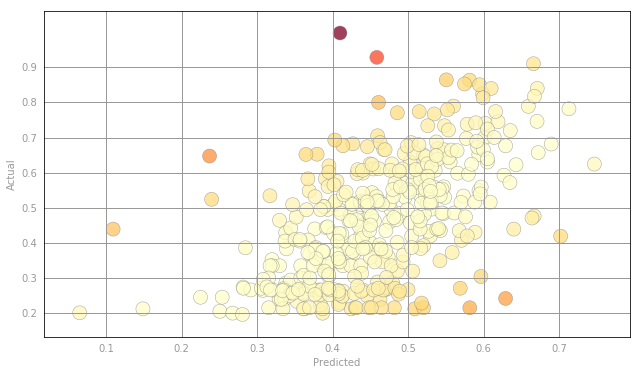

In [ ]:
# best model's prediction
predictions = np.asarray(parsed_val_data_df.rdd
                         .map(lambda lp: best_model.predict(lp.features))
                         .collect())
actual = np.asarray(parsed_val_data_df.rdd
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsed_val_data_df.rdd
                   .map(lambda lp: (lp.label, best_model.predict(lp.features)))
                   .map( lambda lp: squared_error(lp))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0,1,0.1), np.arange(0,1,0.1))
# ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
display(fig) 
pass



In [ ]:
# add interaction
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
import itertools

def two_way_interactions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    label = lp.label
    old_features = lp.features
    interactions = itertools.product(old_features, old_features)
    inter_features = [itr[0]*itr[1] for itr in interactions]
    features = np.hstack((old_features, inter_features))
    
    return LabeledPoint(label, features)
    # YOUR CODE HERE
#     raise NotImplementedError()

print(two_way_interactions(LabeledPoint(0.0, [2, 3])))
tmp = parsed_train_data_df.rdd.take(1)[0]
print(tmp)
print(type(two_way_interactions(LabeledPoint(tmp.label, tmp.features)).features.toArray()))


# Transform the existing train, validation, and test sets to include two-way interactions.
# Remember to convert them back to DataFrames at the end.
# take note, job aborted due to stage failure: possible reason: wrong function name used in map, forgot to add [], w
train_data_interact_df = parsed_train_data_df.rdd.map(lambda row: Row(label = two_way_interactions(LabeledPoint(row.label, row.features)).label, features = two_way_interactions(LabeledPoint(row.label, row.features)).features)).toDF()

val_data_interact_df = parsed_val_data_df.rdd.map(lambda row: Row(label = two_way_interactions(LabeledPoint(row.label, row.features)).label, features = two_way_interactions(LabeledPoint(row.label, row.features)).features)).toDF()

test_data_interact_df = parsed_test_data_df.rdd.map(lambda row: Row(label = two_way_interactions(LabeledPoint(row.label, row.features)).label, features = two_way_interactions(LabeledPoint(row.label, row.features)).features)).toDF()

# YOUR CODE HERE
# raise NotImplementedError()


(0.0,[2.0,3.0,4.0,6.0,6.0,9.0])
Row(features=[-3.63181047324306, -4.391340151589837, -0.35975487864180605, -1.0429614075340423, -1.3435161843385572, -0.7218276109266315, -0.2550860245063476, 1.0464232224476606, -0.3242275365260396, 0.6752835434118533, -0.26580629517503157, -0.3084139884548128, 0.3123195306615099, -1.4058064132746488], label=0.3458022475242615)
<class 'numpy.ndarray'>

In [ ]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10
# train_data_interact_df

model_interact = LinearRegressionWithSGD.train(data = train_data_interact_df.rdd
                                              .map(lambda lp: LabeledPoint(lp.label, lp.features)),
                                              iterations=numIters,
                                              step=alpha,
                                              miniBatchFraction=miniBatchFrac,
                                              initialWeights=None,
                                              regParam=reg,
                                              regType=regType,
                                              intercept=useIntercept)

labels_and_preds_interact = val_data_interact_df.rdd.map(lambda lp: (lp.label, float(model_interact.predict(lp.features))))
labels_and_preds_interact_df = sqlContext.createDataFrame(labels_and_preds_interact, ["label", "prediction"])
rmse_val_interact = calc_RMSE(labels_and_preds_interact_df)

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\t\n\tLR1 = {1:.3f}\n\tLRGrid = ' +
       '{2:.3f}\n\tLRInteract = {3:.3f}').format(rmse_val_base, rmse_val_LR1,
                                                 rmse_val_LR_grid, rmse_val_interact))

# YOUR CODE HERE
# raise NotImplementedError()


Validation RMSE:
	Baseline = 0.170
	
	LR1 = 0.147
	LRGrid = 0.139
	LRInteract = nan

In [ ]:
print(rmse_val_interact)
labels_and_preds_interact_test = test_data_interact_df.rdd.map(lambda lp: (lp.label, float(model_interact.predict(lp.features))))
labels_and_preds_interact_test_df = sqlContext.createDataFrame(labels_and_preds_interact_test, ["label", "prediction"])
rmse_test_interact = calc_RMSE(labels_and_preds_interact_test_df)

print (('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmse_test_base, rmse_test_interact)))

nan
Test RMSE:
	Baseline = 0.159
	LRInteract = nan